In [1]:
using NNGCM
using LinearAlgebra
using Random
using Distributions
using JLD2
include("Barotropic.jl")
include("../../Inversion/Plot.jl")

Gaussian_2d (generic function with 5 methods)

# Barotropic flow


The barotropic vorticity equation describes the evolution of a non-divergent, incompressible flow on the surface of the earth:

$$
\begin{align*}
        &\frac{\partial \omega}{\partial t} = - v \cdot \nabla (\omega + f), \\
        &\nabla^2\psi = \omega \qquad v = k \times \nabla\psi,
\end{align*}
$$

where $\omega$ and $\psi$ are vorticity and streamfunction, respectively. $v$ is the non-divergent flow velocity, $k$ is the unit vector in the radial direction, and $f = 2\Omega \sin(\phi)$ is the Coriolis force, depending on the latitude $\phi$. The angular velocity is $\Omega = 7.292\times10^5 s^{-1}$.


# Spherical coordinates 


Longitude $\lambda$ ranges from $0$ to $2\pi$, and latitude $\phi$ from $−\pi/2$ at the South Pole to $\pi/2$ at the North Pole. The transformation is 

$$
\begin{align*}
x &= r \cos \lambda \cos \phi \\
y &= r \sin \lambda \cos \phi \\
z &= r \sin \phi
\end{align*}
$$

Let $v_{\lambda}$ be the zonal (eastward) velocity and $v_{\phi}$ be the northward velocity at constant radius.
The velocity becomes 
$$v =  v_{\lambda} e_{\lambda} + v_{\phi}e_{\phi} \qquad e_{\lambda} = (- \sin \lambda,\, \cos \lambda,\,  0)\quad  e_{\phi} = (-\cos \lambda \sin \phi, \, -\sin \lambda \sin \phi, \, \cos \phi) $$


The divergence operator and the radial component of the vorticity operator on the sphere are 
$$
\begin{align*}
\nabla v = \frac{1}{R\cos \phi} \frac{\partial v_{\lambda}}{\partial \lambda} + \frac{1}{R\cos \phi} \frac{\partial }{\partial \phi} \Big(v_{\phi} \cos \phi \Big)\\
\nabla \times v = \frac{1}{R\cos \phi} \frac{\partial v_{\phi}}{\partial \lambda} - \frac{1}{R\cos \phi} \frac{\partial }{\partial \phi} \Big(v_{\lambda} \cos \phi \Big)
\end{align*}
$$
here $v$ can be an arbitrary vector field on the sphere.

The flow filed can be reconstitued from the streamfunction $\psi$ as 

$$v_{\lambda} = -\frac{1}{R}\frac{\partial \psi}{\partial \phi} \qquad v_{\psi} = \frac{1}{R\cos\phi}\frac{\partial \psi}{\partial \lambda}$$

The barotropic vorticity equation can be rewritten as 

$$
\begin{align*}
        \frac{\partial \omega}{\partial t} &= -  \nabla v(\omega + f) \\
                                           &= -  \frac{1}{R\cos \phi} \frac{\partial v_{\lambda}(\omega + f)}{\partial \lambda} - \frac{1}{R\cos \phi} \frac{\partial }{\partial \phi} \Big(v_{\phi}(\omega + f) \cos \phi \Big)\\
                                           &= -  \frac{ v_{\lambda}}{R\cos \phi} \frac{\partial(\omega + f)}{\partial \lambda} - \frac{v_{\phi}}{R} \frac{\partial (\omega + f)}{\partial \phi}\\
                                           &= \frac{ 1}{R^2\cos \phi} \Big[\frac{\partial \psi}{\partial \phi}\frac{\partial(\omega + f)}{\partial \lambda} - \frac{\partial \psi}{\partial \lambda}\frac{\partial (\omega + f)}{\partial \phi}\Big]\\
\end{align*}
$$

We use the Earth radius $R = 6.3712\times10^6~m$.

In [6]:
using NNGCM
using LinearAlgebra
using Random
using Distributions
using JLD2
include("../Barotropic/Barotropic.jl")
include("../../Inversion/Plot.jl")
include("../../Inversion/DF_GMVI.jl")



function smallest_n_indices(A::AbstractMatrix, n::Int)
    # Flatten the array and get the linear indices of the smallest n elements
    linear_indices = partialsortperm(vec(A), 1:n, rev=false)
    # Convert linear indices to Cartesian (2D) indices
    cartesian_indices = CartesianIndices(A)[linear_indices]
    return cartesian_indices
end



num_fourier, nθ = 42, 64 #85, 128
nλ = 2nθ
Δt, end_time =  1800, 86400*4
n_obs_frames = 2
obs_time, nobs = Int64(end_time/n_obs_frames), 100
antisymmetric = false
trunc_N = 8
N_θ = (trunc_N+2)*trunc_N
N_y = nobs*n_obs_frames 
N_f = N_y + N_θ 

obs_coord = zeros(Int64, nobs, 2)
obs_coord[:,1], obs_coord[:, 2] = rand(1:nλ-1, nobs), rand(1:nθ-1, nobs)

# Initialization for false results 
spe_mesh, grid_u_b, grid_v_b, grid_vor_b, spe_vor_b, grid_vor_pert, grid_u, grid_v, grid_vor, spe_vor, init_data = 
Barotropic_Init(num_fourier, nθ; trunc_N = trunc_N, radius = 6371.2e3, m = 4.0, θ0 = 45.0 * pi / 180,  θw = 15.0 * pi / 180.0, A = 0.0, symmetric = false)
barotropic_A0 = Setup_Param(num_fourier, nθ, Δt, end_time, n_obs_frames, obs_coord, antisymmetric, N_y, trunc_N, spe_mesh,
                         grid_u_b, grid_v_b, grid_vor_b, spe_vor_b,      # background velocity/vorticity profiles
                         grid_u, grid_v, grid_vor, spe_vor, init_data);
# Generate reference observation
_, obs_raw_data_A0 = Barotropic_Main(barotropic_A0, barotropic_A0.init_data);




# Initialization for truth resutls
spe_mesh, grid_u_b, grid_v_b, grid_vor_b, spe_vor_b, grid_vor_pert, grid_u, grid_v, grid_vor, spe_vor, init_data = 
Barotropic_Init(num_fourier, nθ; trunc_N = trunc_N, radius = 6371.2e3, m = 2.0, θ0 = 45.0 * pi / 180,  θw = 15.0 * pi / 180.0, A = 8.0e-5, symmetric = false)
barotropic = Setup_Param(num_fourier, nθ, Δt, end_time, n_obs_frames, obs_coord, antisymmetric, N_y, trunc_N, spe_mesh,
                         grid_u_b, grid_v_b, grid_vor_b, spe_vor_b,      # background velocity/vorticity profiles
                         grid_u, grid_v, grid_vor, spe_vor, init_data);
# Generate reference observation
spe_mesh, obs_raw_data = Barotropic_Main(barotropic, barotropic.init_data);


############################# update observation locations
Random.seed!(42)

obs_raw_data_diff = [obs_raw_data["vor"][1] - obs_raw_data_A0["vor"][1], obs_raw_data["vor"][2] - obs_raw_data_A0["vor"][2]]
obs_raw_data_diff_ratio = [abs.(obs_raw_data_diff[1]) ./ abs.(obs_raw_data_A0["vor"][1])  ,  abs.(obs_raw_data_diff[2]) ./ abs.(obs_raw_data_A0["vor"][2]) ]

n_low, n_high = 32, 60
indices = [ [idx[1], idx[2]] for idx in smallest_n_indices((obs_raw_data_diff_ratio[1] + obs_raw_data_diff_ratio[2])[:,n_low:n_high,1], 200) ]
indices = hcat(indices...)'
indices[:, 2] .+= (n_low - 1)
indices = indices[randperm(size(indices, 1))[1:50], :]
obs_coord[1:50,:] = indices

n_low, n_high = 4, 32
indices = [ [idx[1], idx[2]] for idx in smallest_n_indices((obs_raw_data_diff_ratio[1] + obs_raw_data_diff_ratio[2])[:,n_low:n_high,1], 200) ]
indices = hcat(indices...)'
indices[:, 2] .+= (n_low - 1)
indices = indices[randperm(size(indices, 1))[1:50], :]
obs_coord[51:end,:] = indices


obs_coord = zeros(Int64, nobs, 2)
Random.seed!(42)
obs_coord[:,1], obs_coord[:, 2] = rand(1:nλ-1, nobs), rand(1:nθ-1, nobs)



barotropic.obs_coord .= obs_coord


############################ Plot observation data
obs_coord = barotropic.obs_coord
n_obs_frames = barotropic.n_obs_frames
antisymmetric = barotropic.antisymmetric
for i_obs = 1:n_obs_frames
    Lat_Lon_Pcolormesh(spe_mesh, obs_raw_data["vel_u"][i_obs], 1, obs_coord; save_file_name =   "Figs/Barotropic_u-"*string(i_obs)*".pdf", cmap = "viridis", antisymmetric=antisymmetric)
    Lat_Lon_Pcolormesh(spe_mesh, obs_raw_data["vor"][i_obs], 1, obs_coord; save_file_name =   "Figs/Barotropic_vor-"*string(i_obs)*".pdf", cmap = "viridis", antisymmetric=antisymmetric)
end     

# exit()




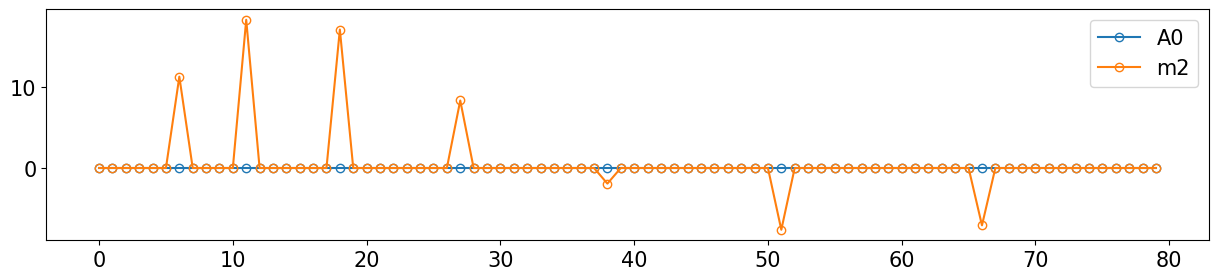

PyObject <matplotlib.legend.Legend object at 0x34d330880>

In [7]:
fig_spe, ax_spe = PyPlot.subplots(sharex=true, sharey=true, figsize=(15,3))

ax_spe.plot(barotropic_A0.init_data, "-o", fillstyle="none", label="A0")
ax_spe.plot(barotropic.init_data, "-o", fillstyle="none", label="m2")
ax_spe.legend()


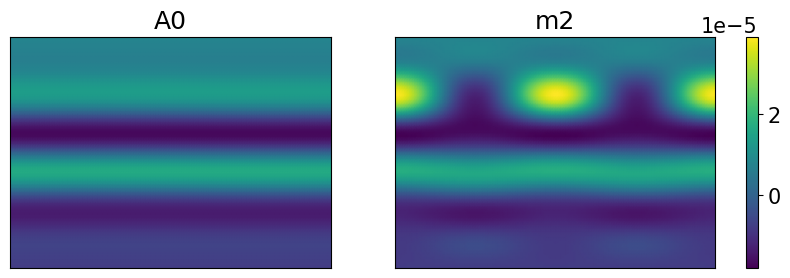

PyObject <matplotlib.colorbar.Colorbar object at 0x34d41d2a0>

In [8]:
fig_vor, ax_vor = PyPlot.subplots(ncols = 2, sharex=true, sharey=true, figsize=(10,3))
for ax in ax_vor ;  ax.set_xticks([]) ; ax.set_yticks([]) ; end
color_lim = (minimum(barotropic.grid_vor), maximum(barotropic.grid_vor))


plot_field(spe_mesh, barotropic_A0.grid_vor, 1,  color_lim, ax_vor[1]) 
ax_vor[1].set_title("A0")

im2 = plot_field(spe_mesh, barotropic.grid_vor, 1,  color_lim, ax_vor[2]) 
ax_vor[2].set_title("m2")


fig_vor.colorbar(im2, ax=ax_vor[:], orientation="vertical", fraction=0.05, pad=0.04)

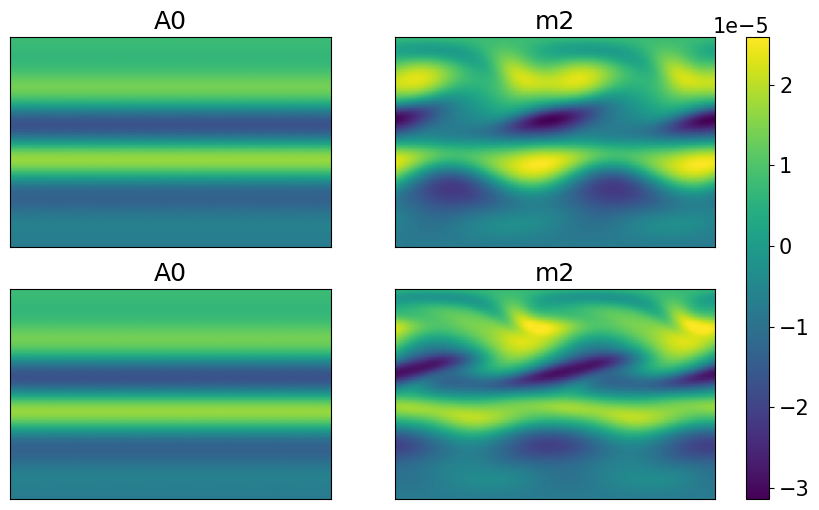

PyObject <matplotlib.colorbar.Colorbar object at 0x34d59c6d0>

In [9]:
fig_vor, ax_vor = PyPlot.subplots(nrows=2, ncols = 2, sharex=true, sharey=true, figsize=(10,6))
for ax in ax_vor ;  ax.set_xticks([]) ; ax.set_yticks([]) ; end
color_lim = (minimum(obs_raw_data["vor"][1]), maximum(obs_raw_data["vor"][1]))

for obs_time = 1:2
    plot_field(spe_mesh, obs_raw_data_A0["vor"][obs_time], 1,  color_lim, ax_vor[obs_time,1]) 
    ax_vor[obs_time,1].set_title("A0")
    
    im2 = plot_field(spe_mesh, obs_raw_data["vor"][obs_time], 1,  color_lim, ax_vor[obs_time,2]) 
    ax_vor[obs_time,2].set_title("m2")
    
end

fig_vor.colorbar(im2, ax=ax_vor[:], orientation="vertical", fraction=0.05, pad=0.04)

In [10]:
###################################################
y_noiseless_A0 = convert_obs(barotropic.obs_coord, obs_raw_data_A0; antisymmetric=barotropic.antisymmetric)
y_noiseless = convert_obs(barotropic.obs_coord, obs_raw_data; antisymmetric=barotropic.antisymmetric)


μ_0 = zeros(Float64, N_θ)  # prior/initial mean 
σ_0 = 10.0
σ_η = 1.0e-6
Random.seed!(123);
a = 0.00066
y_obs = (0.5 + a)*y_noiseless + (0.5 - a)*y_noiseless_A0   #rand(Normal(0, σ_η), N_y)
Σ_η = Array(Diagonal(fill(σ_η^2, N_y)))


func_F(x) = barotropic_F(barotropic, (y_obs, μ_0, σ_η, σ_0), x);
Phi(x, θ) = [0.5*[(y_obs  - x)./σ_η]' * [(y_obs  - x)./σ_η], 0.5*[(μ_0 - θ)./σ_0]' * [(μ_0 - θ)./σ_0], 0.5*[(y_obs  - x)./σ_η; (μ_0 - θ)./σ_0]' * [(y_obs  - x)./σ_η; (μ_0 - θ)./σ_0]]

Phi (generic function with 1 method)

In [11]:
@info "likelyhood", "prior"
@info Phi(y_noiseless_A0, barotropic_A0.init_data), Phi(y_noiseless, barotropic.init_data) 

[ Info: ("likelyhood", "prior")
[ Info: ([952.2753600739294, 0.0, 952.2753600739294], [947.2605938931849, 4.72657586407163, 951.9871697572564])
